In [1]:
import os
# !{os.sys.executable} -m pip install gymnasium
# !{os.sys.executable} -m pip install cmake 
# !{os.sys.executable} -m pip install ale-py
# !{os.sys.executable} -m pip install atari-py
# !{os.sys.executable} -m pip install Pillow
# !{os.sys.executable} -m pip install ipython
# !{os.sys.executable} -m pip install pygame
# !{os.sys.executable} -m pip install tensorboardX
# !{os.sys.executable} -m pip install "gymnasium[atari, accept-rom-licesnse]"
# !{os.sys.executable} -m pip install "autorom[accept-rom-license]"
# !{os.sys.executable} -m pip install torch
# !{os.sys.executable} -m pip install torchvision

In [2]:
# Import useful packages

import os
import sys
import gymnasium as gym
import random
import numpy as np
import time
import matplotlib.pyplot as plt

import torch
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms.functional as Fv
import torchvision.transforms as transforms
from torchinfo import summary

from DTQN_Model import DTQN
from tensorboardX import SummaryWriter

from collections import namedtuple, deque


In [3]:
env_name = "ALE/Breakout-v5" # atari

CNN_mode = True # False for mlp, True for CNN

gamma = 0.99
batch_size = 32 # 32
lr = 0.00001 #1lr = 0.0001
initial_exploration = 10000 #1000
goal_score = 200
log_interval = 1 # 10
update_target = 25 # 100
replay_memory_capacity = 1000
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

env=gym.make(env_name)

Device: cuda


In [4]:
Transition = namedtuple(
    'Transition', ('state', 'next_state', 'action', 'reward', 'mask')
)

class Memory_DTQN(object):
    def __init__(self, capacity):
        self.memory = deque(maxlen=capacity)
        self.capacity = capacity

    def push(self, state, next_state, action, reward, mask):
        self.memory.append(Transition(state, next_state, action, reward, mask))
    
    def sample(self, batch_size):
        transitions = random.sample(self.memory, batch_size)
        batch = Transition(*zip(*transitions))
        return batch
    
    def __len__(self):
        return len(self.memory)

In [5]:
def get_action(state, target_net, epsilon, env):
    if np.random.rand() <= epsilon:
        return env.action_space.sample() #random action
    else:
        return target_net.get_action(state)

In [6]:
env=gym.make(env_name)

state_size = env.observation_space.low.size
action_size = env.action_space.n

print("state size:", state_size)
print("action size:", action_size)

online_net = DTQN(state_size, action_size).to(device)
target_net = DTQN(state_size, action_size).to(device)

online_net.train()
target_net.train()
writer = SummaryWriter('logs')

print(summary(online_net, input_size=(batch_size, state_size)))

optimizer = optim.Adam(online_net.parameters(), lr=lr)
N_EPISODES = 5000

#initialize running variables
running_score = 0
epsilon = 1.0
epsilon_decay_rate = 0.000005 #0.000005
steps = 0
loss = 0

# initialize the memory bank
memory = Memory_DTQN(replay_memory_capacity)

# Before training
loss_record = []
scores_record = []
best_score = float('-inf')  # Initialize best_score with negative infinity
best_online_net_weights = None
best_target_net_weights = None

state size: 100800
action size: 4


c:\Users\evank\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Layer (type:depth-idx)                        Output Shape              Param #
DTQN                                          [32, 4]                   281,152
├─Linear: 1-1                                 [32, 64]                  6,451,264
├─TransformerEncoder: 1-2                     [32, 64]                  --
│    └─ModuleList: 2-1                        --                        --
│    │    └─TransformerEncoderLayer: 3-1      [32, 64]                  281,152
│    │    └─TransformerEncoderLayer: 3-2      [32, 64]                  281,152
│    │    └─TransformerEncoderLayer: 3-3      [32, 64]                  281,152
├─Linear: 1-3                                 [32, 32]                  2,080
├─Linear: 1-4                                 [32, 4]                   132
Total params: 7,578,084
Trainable params: 7,578,084
Non-trainable params: 0
Total mult-adds (M): 231.90
Input size (MB): 12.90
Forward/backward pass size (MB): 1.75
Params size (MB): 28.99
Estimated Total Size (MB)

c:\Users\evank\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\functional.py:5476: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)
  attn_output = scaled_dot_product_attention(q, k, v, attn_mask, dropout_p, is_causal)


In [7]:
for episode in range(N_EPISODES):
    done = False

    score = 0
    state = env.reset()[0]
    state, _, _, _, _ = env.step(1)
    state = torch.Tensor(state).to(device)
    state = state.view(-1).unsqueeze(0)

    while not done:
        state, _, _, _, _ = env.step(1)
        state = torch.Tensor(state).to(device)
        state = state.view(-1).unsqueeze(0)
        steps += 1
        action = get_action(state, target_net, epsilon, env)
        
        # next_state, reward, done, _, _ = env.step(action) # 5 outputs
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        
        next_state = torch.Tensor(next_state).to(device)
        next_state = next_state.view(-1).unsqueeze(0)

        mask = 0 if done else 1 #don't know what this line does

        # i assume this is the penalty function?
        reward = reward if not done or score == 499 else -1

        action_one_hot = np.zeros(action_size)
        action_one_hot[action] = 1

        # add to memory bank
        memory.push(state, next_state, action_one_hot, reward, mask)

        score += reward
        state = next_state

        if steps > initial_exploration:
            epsilon -= epsilon_decay_rate
            epsilon = max(epsilon, 0.01)

            # process the batch
            batch = memory.sample(batch_size)
            # print("batch", batch)
            states = torch.stack(batch.state).to(device)
            next_states = torch.stack(batch.next_state).to(device)
            actions = torch.Tensor(np.array(batch.action)).float().to(device)
            rewards = torch.Tensor(batch.reward).to(device)
            masks = torch.Tensor(batch.mask).to(device)
            
            # print("states", states.shape)
            # print("states", states.shape)
            # print("next states", next_states.shape)
            # print("actions", actions.shape)
            q_values = online_net(states.squeeze(1)).gather(1, actions.long())
            # q_values = online_net(states).to(device)
            next_q_values = target_net(next_states.squeeze(1)).gather(1, actions.long())
            
            masks_broadcasted = masks.unsqueeze(1).to(device)  # Shape [32, 1]
            duplicated_rewards = rewards.unsqueeze(1).repeat(1, action_size).to(device)

            
            q_target  = duplicated_rewards + gamma * next_q_values*masks_broadcasted
            q_target.to(device)

            # print("q_values", q_values.shape, "q_target", q_target.shape)
            loss = F.mse_loss(q_values, q_target)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if steps % initial_exploration:
                target_net.load_state_dict(online_net.state_dict())
    score = score if score == 500.0 else score + 1
    if running_score == 0:
        running_score = score
    else:
        running_score = 0.99 * running_score + 0.01 * score

    scores_record.append(running_score)
    loss_record.append(loss)

     # Update best_score and store best model weights in memory
    if running_score > best_score:
        best_score = running_score
        best_online_net_weights = online_net.state_dict()
        best_target_net_weights = target_net.state_dict()
    
    if episode % log_interval == 0:
        print('\r{} episode | score: {:.2f} | loss: {:.5f} | epsilon: {:.2f}'.format(
            episode, running_score, loss, epsilon), end='')
        writer.add_scalar('log/score', float(running_score), episode) # i don't know what this does
        writer.add_scalar('log/loss', float(loss), episode)    

    if running_score > goal_score:
        break

2740 episode | score: 0.11 | loss: 0.00036 | epsilon: 0.01

In [ ]:
# Create the saved_models folder if it doesn't exist
if not os.path.exists('saved_models/breakout_DTQN'):
    os.makedirs('saved_models/breakout_DTQN')

# Generate a unique train_number based on current timestamp
train_number = time.strftime("%Y%m%d_%H%M%S")
train_folder = f'saved_models/breakout_DTQN/train_{train_number}'

# Create the train_number subfolder inside saved_models
if not os.path.exists(train_folder):
    os.makedirs(train_folder)

# Save the model to the train_number subfolder
torch.save(online_net.state_dict(), f'{train_folder}/online_net.pth')
torch.save(target_net.state_dict(), f'{train_folder}/target_net.pth')

# Save the best model weights to the train_number subfolder
torch.save(best_online_net_weights, f'{train_folder}/best_online_net.pth')
torch.save(best_target_net_weights, f'{train_folder}/best_target_net.pth')

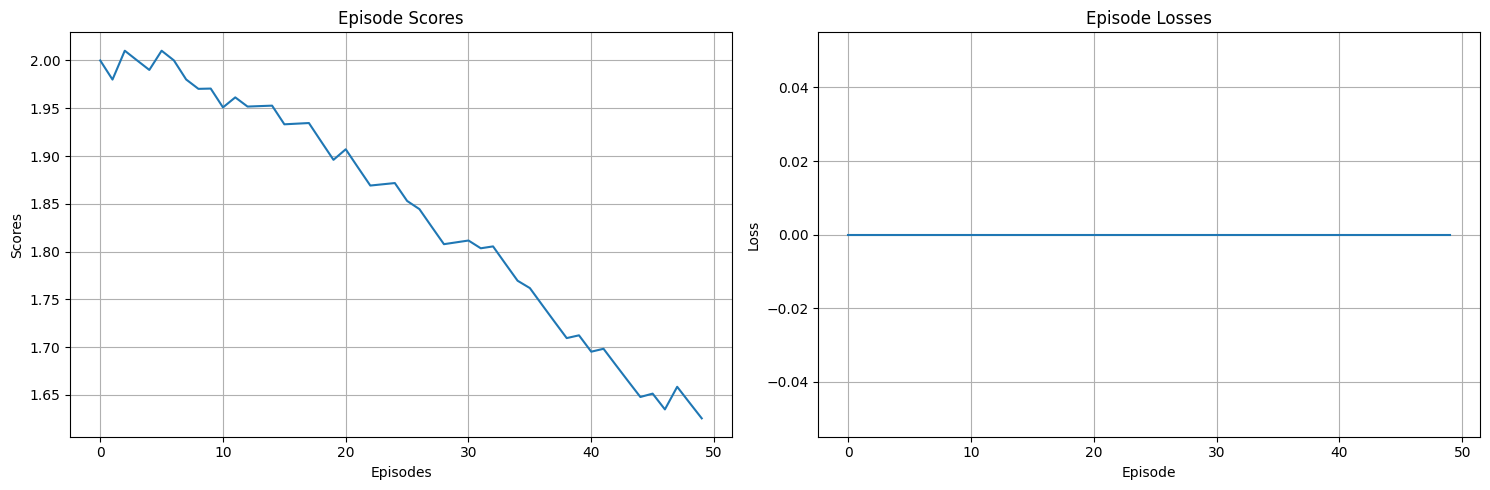

In [ ]:
def convert_to_ints(lst):
    return [int(elem.item()) if torch.is_tensor(elem) else int(elem) for elem in lst]

# Plotting the metrics
plt.figure(figsize=(15, 5))

# Plot Rewards
plt.subplot(1, 2, 1)
plt.plot(scores_record)
plt.title('Episode Scores')
plt.xlabel('Episodes')
plt.ylabel('Scores')
plt.grid(True)

# Plot Losses (assuming you have a list of losses)
plt.subplot(1, 2, 2)
plt.plot(convert_to_ints(loss_record))
plt.title('Episode Losses')
plt.xlabel('Episode')
plt.ylabel('Loss')
plt.grid(True)

# Save the plots to the train_number subfolder
plt.savefig(f'{train_folder}/metrics_plot.png')

plt.tight_layout()
plt.show()